## Imports/SetUp

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install torchmetrics

In [18]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import nltk
import os
import re
import seaborn as sns
from tqdm import tqdm
import pickle
import numpy as np
import copy

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
import time
from torchmetrics import Accuracy

# model assessment
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from matplotlib import pyplot as plt

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device being used:", device)

Device being used: cpu


## Load the large subset 

In [46]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'
X_train = np.load(f'{path}/X_train_large.npy', allow_pickle=True)
y_train = np.load(f'{path}/y_train_large.npy', allow_pickle=True)
X_test = np.load(f'{path}/X_test_large.npy', allow_pickle=True)
y_test = np.load(f'{path}/y_test_large.npy', allow_pickle=True)

## Dataloader

In [48]:
class AmazonFoodReviewSentences(Dataset):

    def __init__(self, path, dataset_type='train'):
        self.X = np.load(f'{path}/X_{dataset_type}_large.npy', allow_pickle=True)
        self.y = np.load(f'{path}/y_{dataset_type}_large.npy', allow_pickle=True)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        return (X_sample, y_sample)

In [49]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'

train_dataset = AmazonFoodReviewSentences(path=path, dataset_type='train')
test_dataset = AmazonFoodReviewSentences(path=path, dataset_type='test')

In [43]:
# hyperparameter
batch_size = 16

In [50]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
model.eval()

In [70]:
def get_bert_embeddings(data_loader, size, tokenizer, model):
    max_len = 50
    embeddings = np.zeros((size, max_len, 768))
    i = 0
    for sample in tqdm(data_loader):
        X_sample, y_sample = sample
        encoded = tokenizer.batch_encode_plus(X_sample, max_length=max_len, padding='max_length', truncation=True)
        encoded = {key:torch.LongTensor(value) for key, value in encoded.items()}
        with torch.no_grad():
            outputs = model(**encoded)
        embedding = outputs.last_hidden_state
        sample_len = embedding.shape[0]
        embeddings[i:i+sample_len] = embedding
        i += sample_len
    return embeddings

In [71]:
train_bert_embeddings = get_bert_embeddings(train_loader, len(train_dataset), tokenizer, model)

100%|██████████| 500/500 [28:23<00:00,  3.41s/it]


In [73]:
test_bert_embeddings = get_bert_embeddings(test_loader, len(test_dataset), tokenizer, model)

100%|██████████| 125/125 [06:17<00:00,  3.02s/it]


In [74]:
# saving vertorized vectors
vector_type = "bert"

pickle.dump(train_bert_embeddings, open(f"{path}/X_train_{vector_type}_large_768","wb"))
pickle.dump(test_bert_embeddings, open(f"{path}/X_test_{vector_type}_large_768","wb"))

## Dataloader for BERT embeddings

In [77]:
class AmazonFoodReview(Dataset):

    def __init__(self, path, dataset_type='train'):
        self.X = np.load(f'{path}/X_{dataset_type}_bert_large_768', allow_pickle=True)
        self.y = np.load(f'{path}/y_{dataset_type}_large.npy', allow_pickle=True)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X_sample = self.X[idx]
        y_sample = self.y[idx]
        return (X_sample, y_sample)

In [78]:
path = '/content/drive/Shareddrives/CIS 519 Project/subset_data'

train_dataset = AmazonFoodReview(path=path, dataset_type='train')
test_dataset = AmazonFoodReview(path=path, dataset_type='test')

## LSTM Model to be trained

In [79]:
# lstm
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, bidirectional=False):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim1, batch_first=True, bidirectional=bidirectional)
        self.fc1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.bifc = nn.Linear(2*hidden_dim1, output_dim)
        self.bidirectional = bidirectional
        
    def forward(self, embeddings):
        out, (h_n, c_n) = self.lstm(embeddings)
        lstm_output = h_n[0]
        if self.bidirectional:
            opp_output = h_n[-1]
            lstm_output = torch.stack([lstm_output, opp_output], axis=0)
            logits = self.bifc(lstm_output).squeeze(1)
        else:
            linear1_out = self.relu(self.fc1(lstm_output))
            logits = self.fc2(linear1_out).squeeze(1)
        return logits

In [80]:
def evaluate(data_loader, model, criterion, metric):
    model.eval()

    total_loss = 0
    total_acc = 0
    for sample in tqdm(data_loader):
        X_batch, y_batch = sample

        X_batch = X_batch.type(torch.float32).to(device)
        y_batch = y_batch.type(torch.float32).to(device)

        logits = model(X_batch)

        loss = criterion(logits, y_batch)
        total_loss += loss.item()

        batch_accuracy = metric(logits, y_batch)
        total_acc += batch_accuracy

    total_loss /= len(data_loader)
    total_acc /= len(data_loader)
    return total_loss, total_acc.item()

In [81]:
def training_loop(train_loader, test_loader, input_dim, hidden_dim1, hidden_dim2, output_dim, lr=1e-3, epochs=2, device='cuda'):

    model = LSTM(input_dim, hidden_dim1, hidden_dim2, output_dim)
    model.to(device)

    epoch_loss_all = []
    epoch_acc_all = []
    train_loss_all = []
    train_acc_all = []
    test_loss_all = []
    test_acc_all = []

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    accuracy = Accuracy(task="binary", threshold=0.5).to(device)

    best_test_acc = 0

    for i, epoch in enumerate(range(epochs)):

        epoch_loss = 0
        epoch_accuracy = 0
        print(f"Epoch {i} starting ...\n")
        model.train()

        for sample in tqdm(train_loader):

            optimizer.zero_grad()

            X_batch, y_batch = sample
            X_batch = X_batch.type(torch.float32).to(device)
            y_batch = y_batch.type(torch.float32).to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            batch_accuracy = accuracy(logits, y_batch)
            epoch_accuracy += batch_accuracy
        
        epoch_accuracy /= len(train_loader)
        epoch_loss /= len(train_loader)
        print(f"\nEpoch Loss: {epoch_loss}")
        print(f"Epoch Accuracy: {epoch_accuracy}")
        epoch_loss_all.append(epoch_loss)
        epoch_acc_all.append(epoch_accuracy.item())

        print("Evaluating created model...")
        train_loss, train_acc = evaluate(train_loader, model, criterion, accuracy)
        test_loss, test_acc = evaluate(test_loader, model, criterion, accuracy)
        print(f"\nTrain Loss: {train_loss}")
        print(f"Train Accuracy: {train_acc}")
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_acc}")
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        test_loss_all.append(test_loss)
        test_acc_all.append(test_acc)
        print("-----------------------------------\n")

        if best_test_acc < test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), f'{path}/final_model_lstm_word2vec.pt')
    return epoch_loss_all, epoch_acc_all, train_loss_all, train_acc_all, test_loss_all, test_acc_all

In [85]:
# hyperparameters
input_dim = 768
hidden_dim1 = 128
hidden_dim2 = 64
output_dim = 1
batch_size = 64
epochs = 10
learning_rate = 1e-3

In [86]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [87]:
epoch_loss_all, epoch_acc_all, train_loss_all, train_acc_all, test_loss_all, test_acc_all = training_loop(
    train_loader, 
    test_loader,
    input_dim, 
    hidden_dim1, 
    hidden_dim2, 
    output_dim, 
    epochs=epochs, 
    lr = learning_rate, 
    device=device)

Epoch 0 starting ...



100%|██████████| 125/125 [00:35<00:00,  3.56it/s]



Epoch Loss: 0.6940793271064758
Epoch Accuracy: 0.5005000233650208
Evaluating created model...


100%|██████████| 32/32 [00:04<00:00,  6.77it/s]



Train Loss: 0.6924075274467468
Train Accuracy: 0.5254999995231628
Test Loss: 0.6937383878976107
Test Accuracy: 0.4951171875
-----------------------------------

Epoch 1 starting ...



100%|██████████| 125/125 [00:34<00:00,  3.60it/s]



Epoch Loss: 0.6925386238098145
Epoch Accuracy: 0.512374997138977
Evaluating created model...


100%|██████████| 32/32 [00:04<00:00,  6.52it/s]



Train Loss: 0.6901576075553894
Train Accuracy: 0.5478749871253967
Test Loss: 0.6933404970914125
Test Accuracy: 0.49755859375
-----------------------------------

Epoch 2 starting ...



100%|██████████| 125/125 [00:34<00:00,  3.63it/s]



Epoch Loss: 0.691085223197937
Epoch Accuracy: 0.5182499885559082
Evaluating created model...


100%|██████████| 32/32 [00:04<00:00,  7.50it/s]



Train Loss: 0.6894547533988953
Train Accuracy: 0.5581250190734863
Test Loss: 0.6929194070398808
Test Accuracy: 0.5107421875
-----------------------------------

Epoch 3 starting ...



100%|██████████| 125/125 [00:35<00:00,  3.52it/s]



Epoch Loss: 0.6844933772087097
Epoch Accuracy: 0.5448750257492065
Evaluating created model...


100%|██████████| 32/32 [00:03<00:00,  9.17it/s]



Train Loss: 0.663824556350708
Train Accuracy: 0.5997499823570251
Test Loss: 0.7018339745700359
Test Accuracy: 0.505859375
-----------------------------------

Epoch 4 starting ...



100%|██████████| 125/125 [00:34<00:00,  3.65it/s]



Epoch Loss: 0.6673300399780273
Epoch Accuracy: 0.5901250243186951
Evaluating created model...


100%|██████████| 32/32 [00:04<00:00,  7.98it/s]



Train Loss: 0.6313378233909607
Train Accuracy: 0.659375011920929
Test Loss: 0.7132510393857956
Test Accuracy: 0.49755859375
-----------------------------------

Epoch 5 starting ...



100%|██████████| 125/125 [00:34<00:00,  3.58it/s]



Epoch Loss: 0.6248523387908935
Epoch Accuracy: 0.6449999809265137
Evaluating created model...


100%|██████████| 32/32 [00:05<00:00,  5.95it/s]



Train Loss: 0.589899672985077
Train Accuracy: 0.6787499785423279
Test Loss: 0.7744256034493446
Test Accuracy: 0.50439453125
-----------------------------------

Epoch 6 starting ...



100%|██████████| 125/125 [00:33<00:00,  3.68it/s]



Epoch Loss: 0.5501203534603119
Epoch Accuracy: 0.7143750190734863
Evaluating created model...


100%|██████████| 32/32 [00:03<00:00,  8.87it/s]



Train Loss: 0.44931506872177124
Train Accuracy: 0.8037499785423279
Test Loss: 0.843696491792798
Test Accuracy: 0.50830078125
-----------------------------------

Epoch 7 starting ...



100%|██████████| 125/125 [00:36<00:00,  3.42it/s]



Epoch Loss: 0.4492958252429962
Epoch Accuracy: 0.7799999713897705
Evaluating created model...


100%|██████████| 32/32 [00:03<00:00,  9.22it/s]



Train Loss: 0.3309351781606674
Train Accuracy: 0.8721250295639038
Test Loss: 0.9502118993550539
Test Accuracy: 0.51953125
-----------------------------------

Epoch 8 starting ...



100%|██████████| 125/125 [00:34<00:00,  3.66it/s]



Epoch Loss: 0.33212370812892916
Epoch Accuracy: 0.8533750176429749
Evaluating created model...


100%|██████████| 32/32 [00:03<00:00,  9.56it/s]



Train Loss: 0.22581127822399139
Train Accuracy: 0.9162499904632568
Test Loss: 1.1971242018043995
Test Accuracy: 0.50439453125
-----------------------------------

Epoch 9 starting ...



100%|██████████| 125/125 [00:33<00:00,  3.68it/s]



Epoch Loss: 0.23831283301115036
Epoch Accuracy: 0.8999999761581421
Evaluating created model...


100%|██████████| 32/32 [00:03<00:00,  9.18it/s]


Train Loss: 0.14216800582408906
Train Accuracy: 0.9553750157356262
Test Loss: 1.3949754275381565
Test Accuracy: 0.515625
-----------------------------------



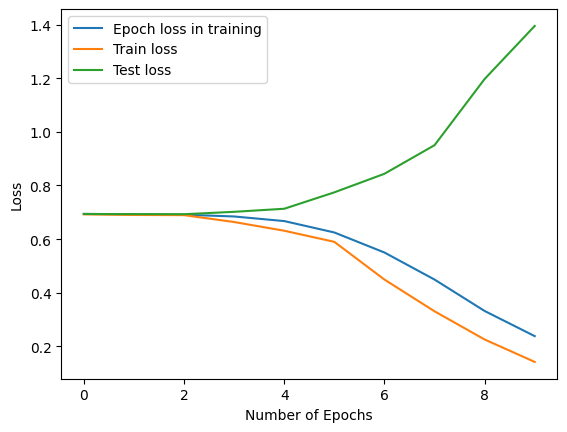

In [88]:
epochs = [i for i in range(len(epoch_loss_all))]
plt.plot(epochs, epoch_loss_all, label='Epoch loss in training')
plt.plot(epochs, train_loss_all, label='Train loss')
plt.plot(epochs, test_loss_all, label='Test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()

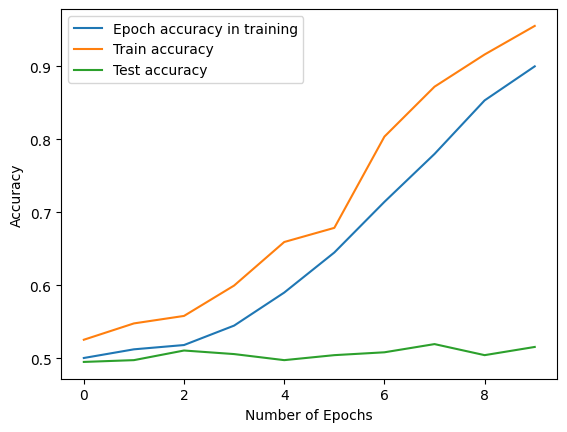

In [89]:
epochs = [i for i in range(len(epoch_acc_all))]
plt.plot(epochs, epoch_acc_all, label='Epoch accuracy in training')
plt.plot(epochs, train_acc_all, label='Train accuracy')
plt.plot(epochs, test_acc_all, label='Test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [90]:
best_model = LSTM(input_dim, hidden_dim1, hidden_dim2, output_dim)
best_model.load_state_dict(torch.load(f'{path}/final_model_lstm_word2vec.pt'))
best_model.to(device)
criterion = nn.BCEWithLogitsLoss()
accuracy = Accuracy(task="binary", threshold=0.5).to(device)
print("Train loss, Train accuracy: ", evaluate(train_loader, best_model, criterion, accuracy))
print()
print("\nTest loss, Test accuracy: ", evaluate(test_loader, best_model, criterion, accuracy))

100%|██████████| 125/125 [00:14<00:00,  8.76it/s]


Train loss, Train accuracy:  (0.33093517673015593, 0.8721250295639038)



100%|██████████| 32/32 [00:03<00:00,  8.19it/s]


Test loss, Test accuracy:  (0.9515098538249731, 0.5166015625)
